In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
INDEX_NAME = os.getenv('PINECONE_INDEX_NAME')

In [5]:
!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

family_photos.zip   100%[===================>] 774.04K  3.89MB/s    in 0.2s    


In [9]:
!unzip -q family_photos.zip

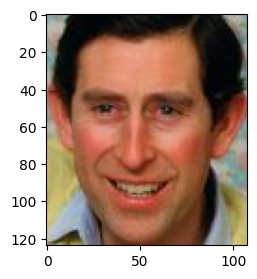

In [5]:
def show_img(f):
  img = plt.imread(f)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

show_img('family/dad/P06260_face5.jpg')

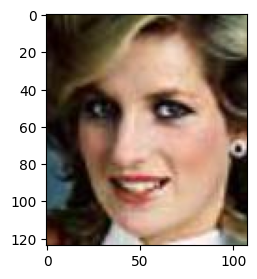

In [6]:
show_img('family/mom/P04407_face2.jpg')

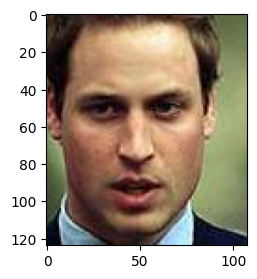

In [7]:
show_img('family/child/P04414_face1.jpg')

In [8]:
MODEL = "Facenet"

pc = Pinecone(api_key=PINECONE_API_KEY)

# if INDEX_NAME in [index.name for index in pc.list_indexes()]:
#     pc.delete_index(name=INDEX_NAME)

# pc.create_index(
#     name=INDEX_NAME, 
#     dimension=512, 
#     metric='dotproduct',
#     spec=ServerlessSpec(
#         cloud='aws', 
#         region='us-east-1'
#     )
# )

In [9]:
def generate_vectors():
  VECTOR_FILE = "./vectors.vec"

  with contextlib.suppress(FileNotFoundError):
    os.remove(VECTOR_FILE)
  with open(VECTOR_FILE, "w") as f:
    for person in ["mom", "dad", "child"]:
      files = glob.glob(f'family/{person}/*')
      for file in tqdm(files):
        try:
          embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
          f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
        except (ValueError, UnboundLocalError, AttributeError) as e:
          print(e)

generate_vectors()

100%|██████████| 93/93 [00:06<00:00, 14.08it/s]


In [10]:
!head -10 vectors.vec

mom:P11987_face1.jpg:[-1.8417969942092896, 0.2739679217338562, 0.044468753039836884, -0.8611029982566833, 0.68535315990448, -0.13261932134628296, -0.33131110668182373, 1.7216206789016724, -0.6115937829017639, -0.2948140501976013, 1.3812776803970337, -1.0561448335647583, -1.031315803527832, -0.14257480204105377, 0.4191492199897766, -0.18285837769508362, 2.0151374340057373, 0.37394803762435913, 0.4505598247051239, -1.2269892692565918, -0.23320409655570984, -1.879880666732788, 0.26880285143852234, 0.30330169200897217, -0.40647298097610474, 0.2601778507232666, 0.2404504120349884, 0.5128799080848694, -1.248457431793213, 0.18616768717765808, 0.2170824110507965, -0.7824193835258484, -0.052353281527757645, 1.0652270317077637, 0.7070255875587463, -0.4827823340892792, 1.175053596496582, 1.6713603734970093, -0.7277414798736572, -0.4402780830860138, -0.6134445071220398, -0.9181232452392578, 0.38785406947135925, -0.0002423301339149475, -0.3855772018432617, -0.5409278869628906, 0.38486337661743164, 

In [11]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./vectors.vec', 'r') as f:
      for line in tqdm(f):
        p, orig_img, v = line.split(':')
        if person == p:
            vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, n_iter=1000,
        verbose=0, metric='euclidean', learning_rate=75)
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

In [12]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 14134.08it/s]


transform 70 vectors


241it [00:00, 18344.99it/s]


transform 93 vectors


241it [00:00, 20708.16it/s]


transform 78 vectors


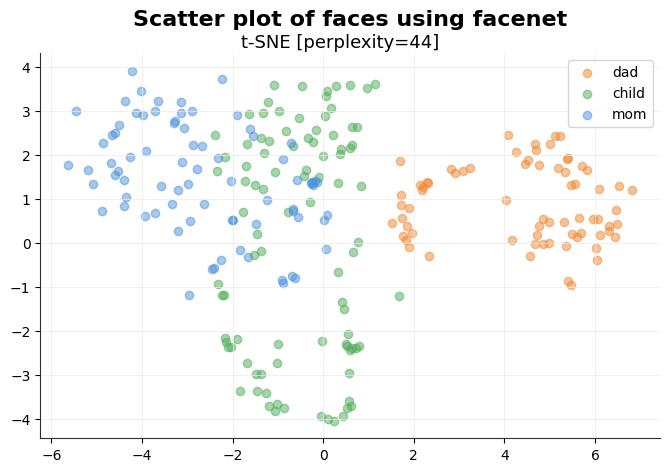

In [13]:
plot_tsne(44, 'facenet')

In [15]:
#pc = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pc.list_indexes()]:
    pc.delete_index(name=INDEX_NAME)

pc.create_index(
    name=INDEX_NAME, 
    dimension=128, 
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws', 
        region='us-east-1'
    )
)

{
    "name": "dl-ai-index",
    "metric": "cosine",
    "host": "dl-ai-index-szkg0wr.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 128,
    "deletion_protection": "disabled",
    "tags": null
}

In [16]:
index = pc.Index(INDEX_NAME)

In [17]:
def store_vectors():
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

241it [00:41,  5.74it/s]


In [20]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 241}},
 'total_vector_count': 241,
 'vector_type': 'dense'}

In [18]:
def test(vec_groups, parent, child):
  index = pc.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [19]:
def compute_scores():
  index = pc.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 5648.66it/s]


DAD --------------------


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]




dad AVG: 0.4332084791600002
MOM --------------------


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]



mom AVG: 0.37811491888


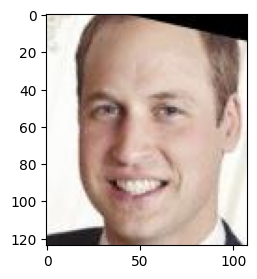

In [21]:
child_base = 'family/child/P06310_face1.jpg'
show_img(child_base)

In [22]:
#Now find closest given we know dad is "most similar"
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

[0.5034345388412476, 1.1029354333877563, -0.8480632305145264, -0.7365075349807739, 0.7583198547363281, 0.4852723777294159, 0.7298290729522705, 1.4870946407318115, -0.1166720986366272, -0.8492704629898071, 0.35565149784088135, -1.2881286144256592, -0.5964650511741638, -1.1971118450164795, -0.1728217601776123, -0.7226609587669373, -1.360188603401184, -3.014233112335205, -0.49746155738830566, -0.1402997523546219, -0.28008028864860535, -0.295367956161499, -0.3175613582134247, -0.5717981457710266, -0.44039955735206604, -0.06698376685380936, 1.366756796836853, 0.20050819218158722, -0.6121864318847656, 0.7146998643875122, -1.5885076522827148, -0.09048543870449066, -1.873830795288086, -0.6179028153419495, 0.3807026147842407, -0.14031891524791718, -1.3785936832427979, -1.4838497638702393, 1.5449597835540771, -0.37778621912002563, -0.8945404291152954, -1.3211232423782349, -2.6536593437194824, -0.4341925382614136, 2.1085562705993652, -1.6897618770599365, 1.4459576606750488, 1.1110585927963257, 0.

In [23]:
query_response = index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

In [24]:
print(query_response)

{'matches': [{'id': 'dad-P06396_face3.jpg',
              'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
              'score': 0.436236173,
              'values': []},
             {'id': 'dad-P11969_face7.jpg',
              'metadata': {'file': 'P11969_face7.jpg', 'person': 'dad'},
              'score': 0.371359855,
              'values': []},
             {'id': 'dad-P11910_face1.jpg',
              'metadata': {'file': 'P11910_face1.jpg', 'person': 'dad'},
              'score': 0.363413751,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 1}}


In [25]:
photo = query_response['matches'][0]['metadata']['file']

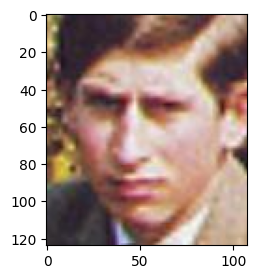

In [26]:
show_img(f'family/dad/{photo}')